In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tqdm.notebook import tqdm

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = False,
            batch_first=True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

In [5]:
path_to_data = "../data.txt"

In [6]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [18]:
from gensim.models import KeyedVectors

In [19]:
%%time
en_emb = KeyedVectors.load_word2vec_format("./pretrained_embeddings/cc.en.300.vec")

CPU times: user 3min 29s, sys: 1.82 s, total: 3min 31s
Wall time: 3min 31s


In [20]:
%%time
ru_emb = KeyedVectors.load_word2vec_format("./pretrained_embeddings/cc.ru.300.vec")

CPU times: user 3min 34s, sys: 2.03 s, total: 3min 36s
Wall time: 3min 36s


In [10]:
from base_transformer import Encoder, Decoder, Seq2Seq

In [11]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 300
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [22]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
enc.apply(initialize_weights)
dec.apply(initialize_weights)

Decoder(
  (tok_embedding): Embedding(14251, 300)
  (pos_embedding): Embedding(100, 300)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attn_layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (enc_attn_layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=300, out_features=300, bias=True)
        (fc_k): Linear(in_features=300, out_features=300, bias=True)
        (fc_v): Linear(in_features=300, out_features=300, bias=True)
        (fc_o): Linear(in_features=300, out_features=300, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=300, out_features=300, bias=True)
        (fc_k): Linear(in_features=300, out_features=300, bias=True)
        (fc_v): Linear(in_features=300, out_feat

In [24]:
en_emb_ordered = [en_emb.get_vector("UNK"), en_emb.get_vector("PAD"), en_emb.get_vector("SOS"), en_emb.get_vector("EOS")]
for token in tqdm(SRC.vocab.itos[4:]):
    try:
        en_emb_ordered.append(en_emb.get_vector(token))
    except KeyError:
        en_emb_ordered.append(np.random.normal(size=ENC_PF_DIM))

  0%|          | 0/10211 [00:00<?, ?it/s]

In [25]:
ru_emb_ordered = [ru_emb.get_vector("UNK"), ru_emb.get_vector("PAD"), ru_emb.get_vector("SOS"), ru_emb.get_vector("EOS")]
for token in tqdm(TRG.vocab.itos[4:]):
    try:
        ru_emb_ordered.append(ru_emb.get_vector(token))
    except KeyError:
        ru_emb_ordered.append(np.random.normal(size=DEC_PF_DIM))

  0%|          | 0/14247 [00:00<?, ?it/s]

In [26]:
en_emb_ordered = np.array(en_emb_ordered)
ru_emb_ordered = np.array(ru_emb_ordered)

<ipython-input-26-fb0667d78696>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  en_emb_ordered = np.array(en_emb_ordered)
<ipython-input-26-fb0667d78696>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ru_emb_ordered = np.array(ru_emb_ordered)


In [27]:
for name, mod in enc.named_modules():
    if name == "embedding":
        mod = nn.Embedding.from_pretrained(torch.FloatTensor(en_emb_ordered))
        
for name, mod in dec.named_modules():
    if name == "embedding":
        mod = nn.Embedding.from_pretrained(torch.FloatTensor(ru_emb_ordered))

In [12]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [29]:
from my_utils import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,797,223 trainable parameters


In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [13]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [14]:
from my_utils import train_transformer, evaluate_transformer, epoch_time

In [35]:
for x in train_iterator:
    break

In [36]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(x.src, x.trg[:,:-1]))
writer.close()

In [37]:
%load_ext tensorboard
%tensorboard --logdir runs

In [38]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_transformer(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_transformer(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/transformer_with_less_heads_with_pretrained_embds.pt')
    
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 34s
	Train Loss: 3.963 | Train PPL:  52.593
	 Val. Loss: 2.524 |  Val. PPL:  12.474
Epoch: 02 | Time: 0m 34s
	Train Loss: 2.429 | Train PPL:  11.349
	 Val. Loss: 2.124 |  Val. PPL:   8.367
Epoch: 03 | Time: 0m 34s
	Train Loss: 1.989 | Train PPL:   7.310
	 Val. Loss: 1.875 |  Val. PPL:   6.522
Epoch: 04 | Time: 0m 34s
	Train Loss: 1.668 | Train PPL:   5.300
	 Val. Loss: 1.744 |  Val. PPL:   5.719
Epoch: 05 | Time: 0m 33s
	Train Loss: 1.421 | Train PPL:   4.143
	 Val. Loss: 1.663 |  Val. PPL:   5.276
Epoch: 06 | Time: 0m 33s
	Train Loss: 1.226 | Train PPL:   3.407
	 Val. Loss: 1.622 |  Val. PPL:   5.061
Epoch: 07 | Time: 0m 34s
	Train Loss: 1.061 | Train PPL:   2.890
	 Val. Loss: 1.622 |  Val. PPL:   5.062
Epoch: 08 | Time: 0m 34s
	Train Loss: 0.929 | Train PPL:   2.532
	 Val. Loss: 1.624 |  Val. PPL:   5.075
Epoch: 09 | Time: 0m 34s
	Train Loss: 0.823 | Train PPL:   2.278
	 Val. Loss: 1.656 |  Val. PPL:   5.237
Epoch: 10 | Time: 0m 34s
	Train Loss: 0.741 | Train PPL

На 8 эпохе val_loss увеличился -> есть переобучение.

In [15]:
torch.cuda.empty_cache()

In [16]:
model.load_state_dict(torch.load('./models/transformer_with_less_heads_with_pretrained_embds.pt'))

<All keys matched successfully>

In [17]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_transformer(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 1.643 | Test PPL:   5.168 | Inference time if batch_size=32: 0.009 sec


In [60]:
from my_utils import transformer_display_attention, transformer_translate_sentence

In [49]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [50]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = в некоторых люксах установлена гидромассажная ванна . <eos>


<ipython-input-48-ff3103009c15>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-ff3103009c15>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


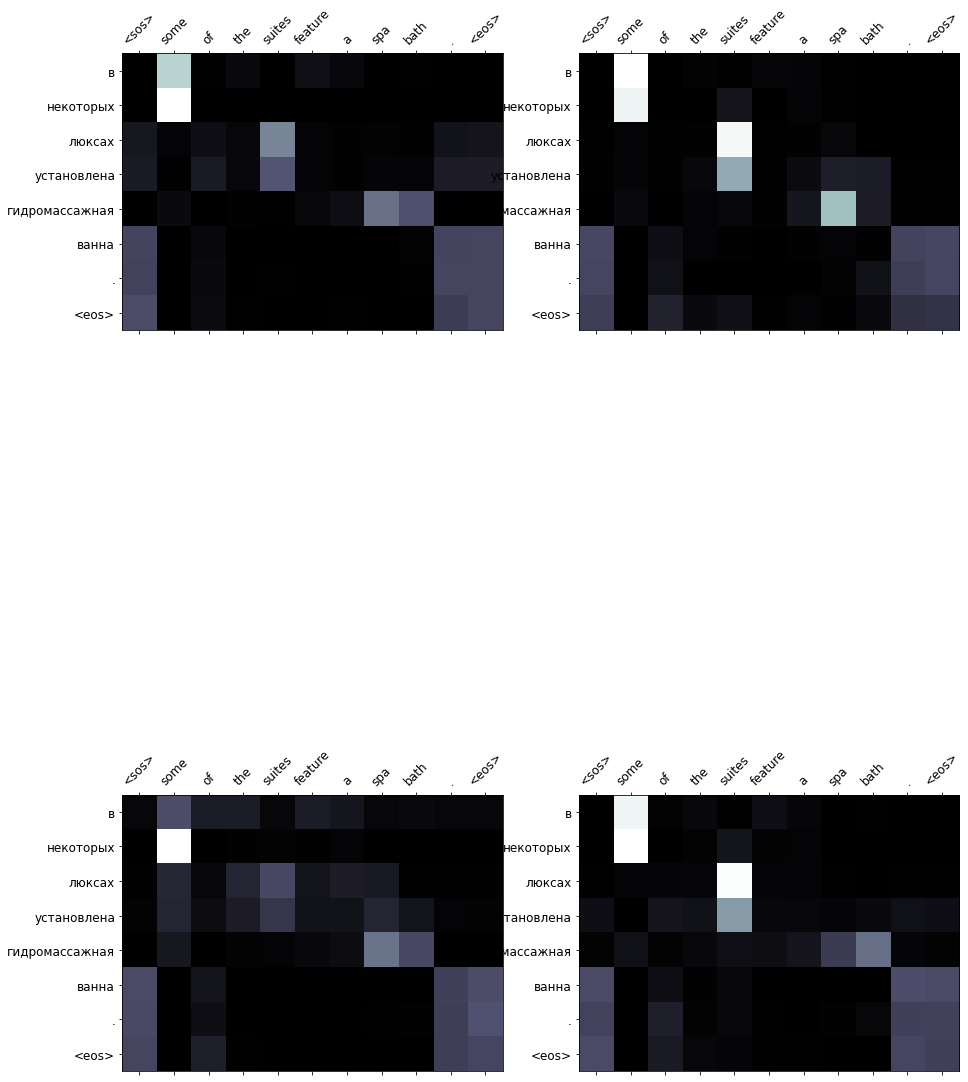

In [51]:
transformer_display_attention(src, translation, attention)

In [46]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = в некоторых люксах установлена гидромассажная ванна . <eos>


<ipython-input-48-ff3103009c15>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-ff3103009c15>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


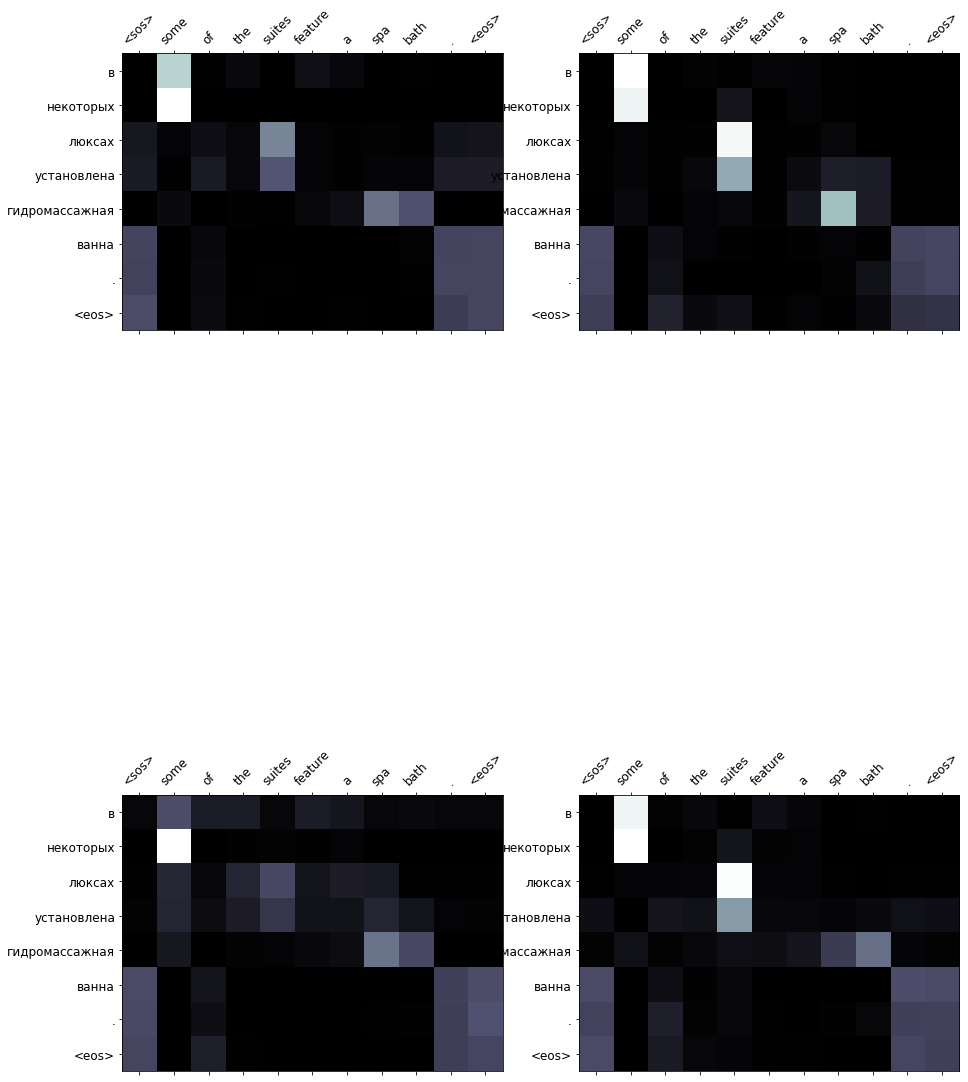

In [52]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-48-ff3103009c15>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-ff3103009c15>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


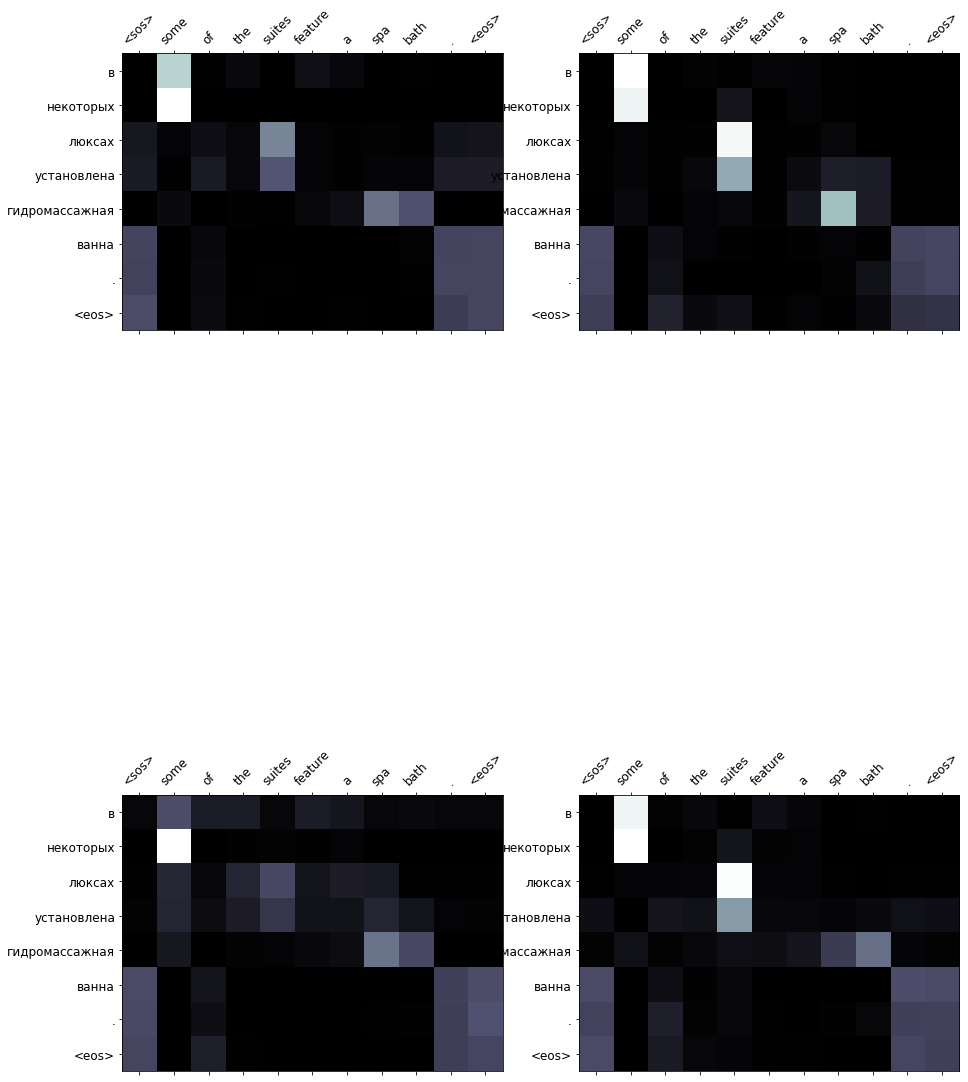

In [53]:
transformer_display_attention(src, translation, attention)

In [54]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей терраса для загара с открытым бассейном и бар у бассейна . <eos>


<ipython-input-48-ff3103009c15>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-ff3103009c15>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


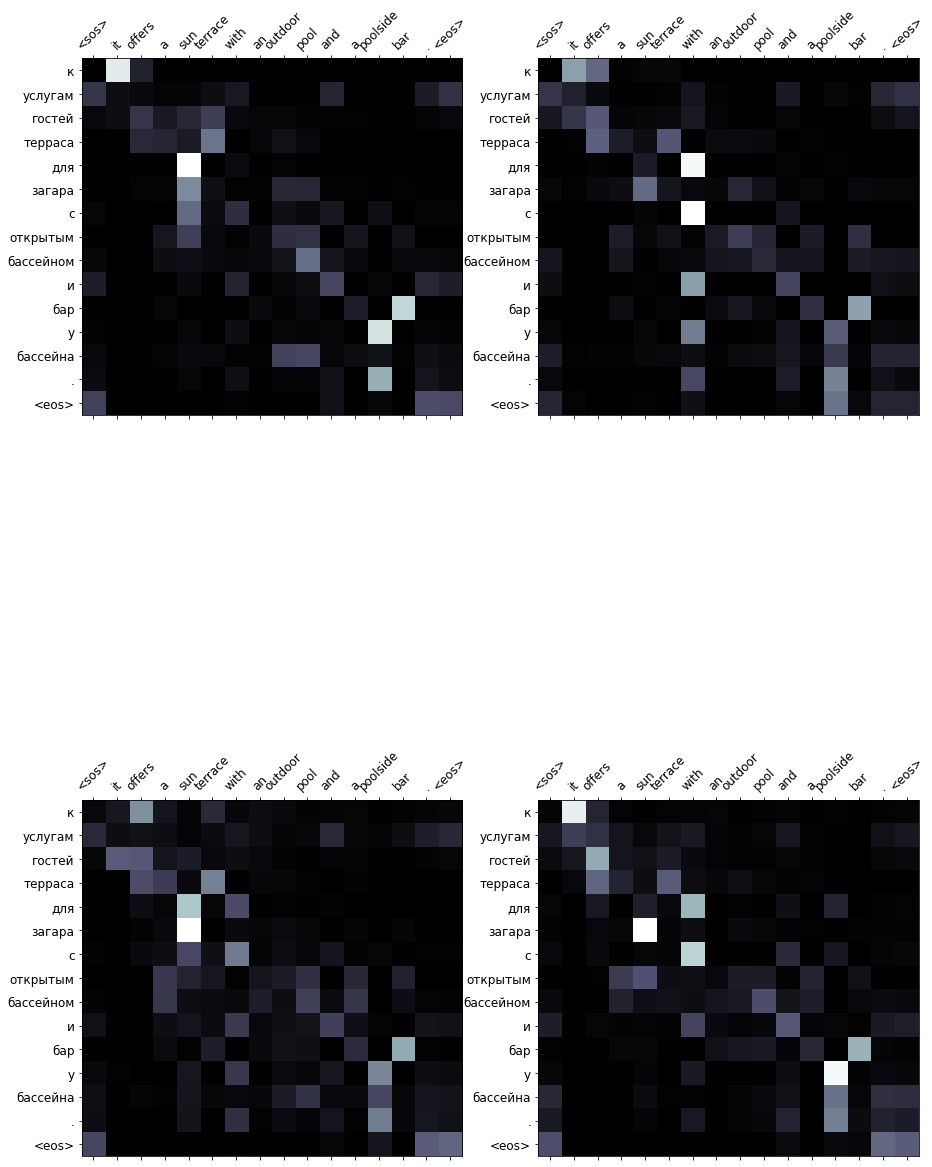

In [55]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-48-ff3103009c15>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-ff3103009c15>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


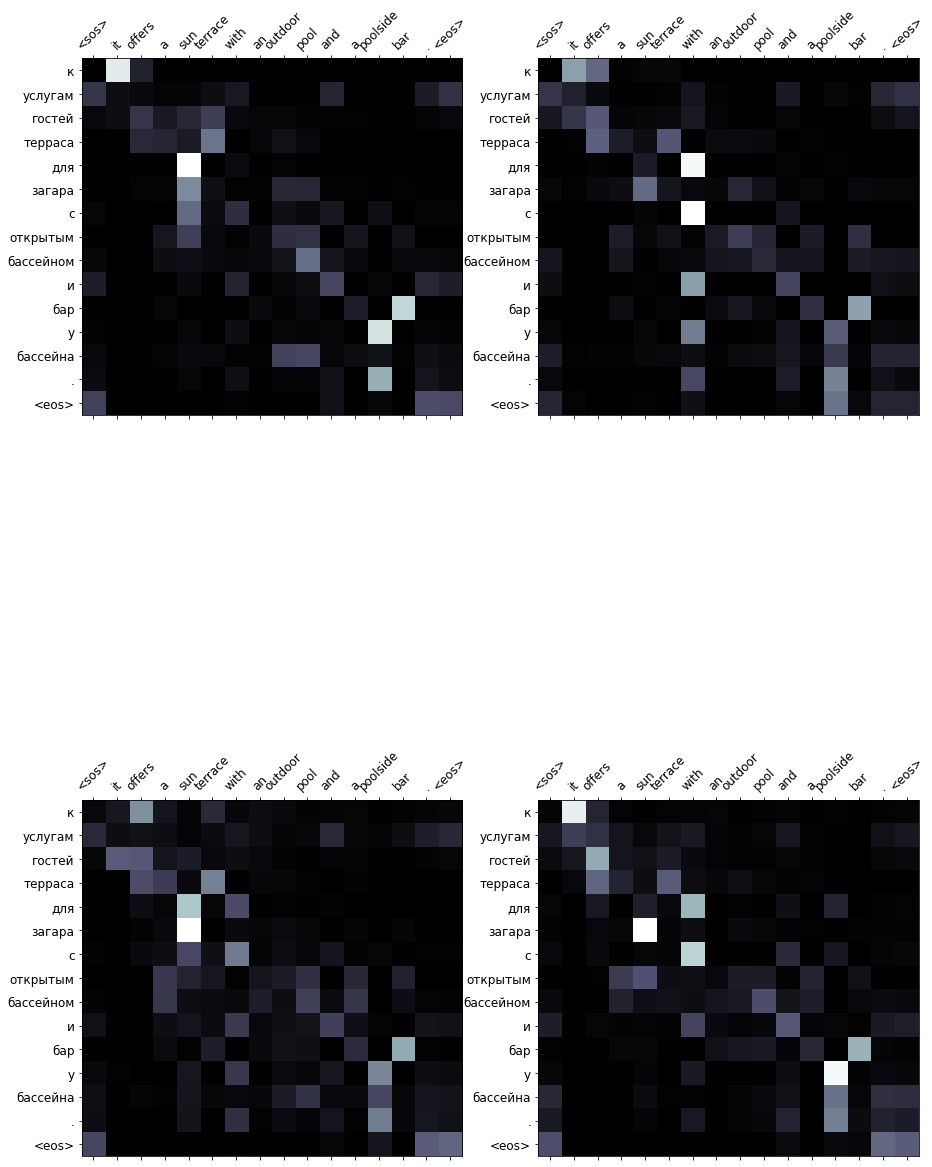

In [56]:
transformer_display_attention(src, translation, attention)

In [57]:
from my_utils import calculate_bleu

In [58]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device, max_len=100)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/7500 [00:00<?, ?it/s]

BLEU score = 26.18
